In [141]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy
import panel as pn
import seaborn as sns

import plotly.express as px 
pn.extension("plotly")
%matplotlib inline


yf.pdr_override()

import hvplot.pandas
import holoviews as hv

In [142]:
combined_production = pd.read_csv("../Data/Total_Production_CLEAN.csv",index_col="Year")
combined_production.head()

,Production (Oil),Production (Alternative)
Year,,
1980,20.474,8.168
1981,20.412,8.421
1982,20.458,9.111
1983,20.528,9.698
1984,21.082,9.990


In [143]:
def alt_base():
    tickers = ['BLX','CIG','ELP','PLUG']
    start = dt.datetime(1975,1,1)
    end = dt.datetime(2021,1,1)
    df = pdr.get_data_yahoo(tickers,start,end)['Adj Close']
    df = df.reset_index()
    
    def to_string(x):
        return str(x)   
        
    df['Date'] = df['Date'].apply(to_string).apply(lambda x: x.split('-')[0]) #! Works: From 1975
    df = df.groupby('Date').last().loc['1999':'2020', :] #! Works: From 175
    return df

In [144]:
def oil_base():
    tickers1 = ['XOM','RDS-B','CVX','BP']
    start = dt.datetime(1975,1,1)
    end = dt.datetime(2021,1,1)
    df = pdr.get_data_yahoo(tickers1,start,end)['Adj Close']
    df = df.reset_index()
    
    def to_string(x):
        return str(x)   
        
    df['Date'] = df['Date'].apply(to_string).apply(lambda x: x.split('-')[0]) #! Works: From 1975
    df = df.groupby('Date').last().loc['1999':'2020', :] #! Works: From 175
    return df

In [145]:
def combined_base():
    combined_base = pd.concat(
                        [alt_base(),oil_base()],
                            axis = 'columns',
                                join = 'inner',
    )
    combined_base_plot = combined_base.hvplot(
                                        title = 'Oil and Alternative Stock Prices from 1999-2020',
                                        ylabel = 'Stock Price',
                                        rot = 90,
                                        width = 1200,
                                        height = 400,
                                        ylim = (0,120),
                                        grid = True
    )
    grid_style = {
            'grid_line_color': 'lightgray', 
            'grid_line_width': 1.5,
            'minor_xgrid_line_color':'lightgray'}
    
    combined_base_plot.opts(
                            fontsize={
                                'title': 20, 
                                'labels': 20, 
                                'xticks': 15, 
                                'yticks': 15,
                                'legend': 20
    },
                            legend_position = 'right',
                            gridstyle = grid_style
    )
    return combined_base_plot
combined_base()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [146]:
def combined_pct_change():
    alt_returns = alt_base().pct_change()
    oil_returns = oil_base().pct_change()
    weights = [0.25,0.25,0.25,0.25]

    alt_port_returns = pd.DataFrame(alt_returns.dot(weights)).dropna()  
    oil_port_returns = pd.DataFrame(oil_returns.dot(weights)).dropna()

    alt_port_returns.columns = ['Alternative Energy']
    oil_port_returns.columns = ['Oil & Gas']

    # Combining the return dataframes
    combined_portfolio_returns = pd.concat(
                                        [alt_port_returns, oil_port_returns], 
                                            axis = 'columns', 
                                                join = 'inner'
    )
    return combined_portfolio_returns

In [147]:
def cumulative_returns():
    cumulative = (1 + combined_pct_change()).cumprod()
    cumulative_plot = cumulative.hvplot(
                                    title = 'Cumulative Returns of Both Industries 2000-2020',
                                    ylabel = 'Cumulative Returns Multiple',
                                    rot = 90,
                                    width = 1200,
                                    height = 400,
                                    shared_axes = False,
                                    grid = True
    )
    grid_style = {
            'grid_line_color': 'lightgray', 
            'grid_line_width': 1.5,
            'minor_xgrid_line_color':'lightgray'}
    
    cumulative_plot.opts(
                        fontsize={
                            'title': 20, 
                            'labels': 20, 
                            'xticks': 15, 
                            'yticks': 15,
                            'legend': 20
    },
                                legend_position = 'top_left',
                                     gridstyle = grid_style
    )
    return cumulative_plot
cumulative_returns()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [148]:
def five_y_rolling_std():
    # Finding the 5-year rolling annual standard deviation 
    df_rolling_std = combined_pct_change().rolling(window = 5).std().dropna()* 100
    
    rolling_std_plot = df_rolling_std.hvplot(
                                        title = '5 Year Rolling Standard Deviation 2004-2020',
                                        ylabel = 'Standard Deviation in %',
                                        rot = 90,
                                        width = 1200,
                                        height = 400,
                                        grid = True,
                                        shared_axes = False
    )
    grid_style = {
            'grid_line_color': 'lightgray', 
            'grid_line_width': 1.5,
            'minor_xgrid_line_color':'lightgray'}
    rolling_std_plot.opts(
                        fontsize={
                            'title': 20, 
                            'labels': 20, 
                            'xticks': 15, 
                            'yticks': 15,
                            'legend': 20
        },
                            legend_position = 'top',
                                gridstyle = grid_style
                                
    )
    return rolling_std_plot
five_y_rolling_std()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [149]:
def oil_and_alt_correlation():
    oil_and_alt_correlation = combined_pct_change().hvplot.scatter(
                                                                title = 'Correlation between Oil Portfolio and Alternative Energy Portfolio Returns', 
                                                                x = 'Oil & Gas', 
                                                                y = 'Alternative Energy',
                                                                s = 100,
                                                                width = 1200,
                                                                height = 400,
                                                                grid = True
    )
    grid_style = {
            'grid_line_color': 'lightgray', 
            'grid_line_width': 1.5,
            'minor_xgrid_line_color':'lightgray'}
    
    oil_and_alt_correlation.opts(
                                fontsize={
                                    'title': 20, 
                                    'labels': 20, 
                                    'xticks': 15, 
                                    'yticks': 15,
        },
                                    gridstyle = grid_style
    
    )
    
    return oil_and_alt_correlation
oil_and_alt_correlation()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


:Scatter   [Oil & Gas]   (Alternative Energy)

In [150]:
combined_pct_change().corr()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


,Alternative Energy,Oil & Gas
Alternative Energy,1.000000,-0.042037
Oil & Gas,-0.042037,1.000000


# This looks like a positive correlation. However, the results say that there is a negative correlation.
THis is due to the fact that the returns of alternative energy have recently shot up in the opposite direction of the oil industry.

In [151]:
def oil_and_alt_std():
    stdev = pd.DataFrame(combined_pct_change().std().sort_values())
    stdev.columns = ['Standard Deviation']
    stdev = stdev.hvplot.bar(
                            title = 'Standard Deviation of Returns of Both the Oil and Alternative Portfolios',
                            width = 1200,
                            height = 400,
                            grid = True
    )
    grid_style = {
            'grid_line_color': 'lightgray', 
            'grid_line_width': 1.5,
            'minor_xgrid_line_color':'lightgray'}
    
    stdev.opts(
            fontsize={
            'title': 20, 
            'labels': 20, 
            'xticks': 20, 
            'yticks': 15,
        }
    )
    return stdev
oil_and_alt_std()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


:Bars   [index]   (Standard Deviation)

In [152]:
def alt_production():
    plot = combined_production["Production (Alternative)"].hvplot.line(
        title="Annual Energy Production from Alternative Energy",
        width=1200,height=400,grid=True)
    
    plot.opts(
            fontsize={
                'title': 20, 
                'labels': 20, 
                'xticks': 20, 
                'yticks': 15,
        }
    )
    
    return plot
alt_production()

:Curve   [Year]   (Production (Alternative))

In [153]:
def oil_production():
    plot = combined_production["Production (Oil)"].hvplot.line(
        title="Annual Energy Production from Oil",width=1200,height=400,grid=True)
    
    plot.opts(
            fontsize={
                'title': 20, 
                    'labels': 20, 
                        'xticks': 20, 
                            'yticks': 15,
        }
    )
    
    return plot
oil_production()

:Curve   [Year]   (Production (Oil))

In [154]:
def comb_production():
    plot = combined_production.hvplot.line(
        title="Annual Energy Production 1980 to 2018",width=1200,height=400,grid=True)
    
    plot.opts(
            fontsize={
                'title': 20, 
                    'labels': 20, 
                        'xticks': 20, 
                            'yticks': 15,
        }
    )
    
    return plot
comb_production()

:NdOverlay   [Variable]
   :Curve   [Year]   (value)

In [155]:
def production_corr():
    plot = combined_production.hvplot.scatter(
        width=1200,height=400,grid=True,
        y='Production (Oil)',x='Production (Alternative)',title="Correlation between Energy Production from Alternatives vs. Oil")
    
    plot.opts(
            fontsize={
                'title': 20, 
                    'labels': 20, 
                        'xticks': 20, 
                            'yticks': 15,
        }
    )
    
    return plot
production_corr()

:Scatter   [Production (Alternative)]   (Production (Oil))

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


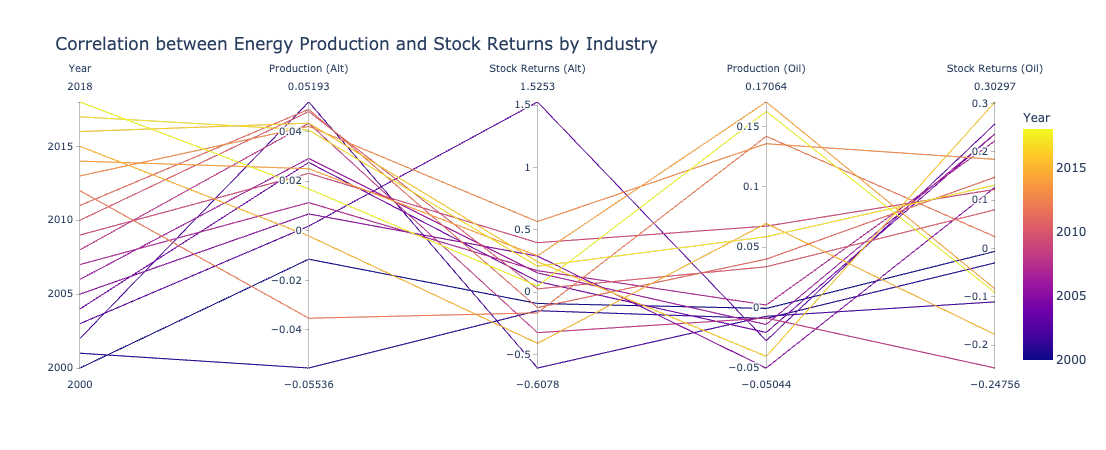

In [156]:
def prod_vs_stock():
    # set stock returns dataframes
    alt_returns = alt_base().pct_change()
    oil_returns = oil_base().pct_change()
    weights = [0.25,0.25,0.25,0.25]

    alt_port_returns = pd.DataFrame(alt_returns.dot(weights)).dropna()  
    oil_port_returns = pd.DataFrame(oil_returns.dot(weights)).dropna()

    alt_port_returns.columns = ['Stock Returns (Alt)']
    alt_port_returns.reset_index(inplace=True)
    alt_port_returns.rename(columns={"Date":"Year"},inplace=True)
    alt_port_returns["Year"] = alt_port_returns["Year"].astype("int")
    alt_port_returns.set_index("Year",inplace=True)
    
    oil_port_returns.columns = ['Stock Returns (Oil)']
    oil_port_returns.reset_index(inplace=True)
    oil_port_returns.rename(columns={"Date":"Year"},inplace=True)
    oil_port_returns["Year"] = oil_port_returns["Year"].astype("int")
    oil_port_returns.set_index("Year",inplace=True)
    
    # set production dataframes
    alt_prod = combined_production.pct_change().dropna().drop(columns="Production (Oil)")
    alt_prod.rename(columns={"Production (Alternative)":"Production (Alt)"},inplace=True)
    
    oil_prod = combined_production.pct_change().dropna().drop(columns="Production (Alternative)")
    
    # combined dataframe with all data
    combined_df = pd.concat([alt_prod,alt_port_returns,oil_prod,oil_port_returns],axis="columns",join="inner")
    combined_df.reset_index(inplace=True)
    
    # plot with parallel coordinates
    plot = px.parallel_coordinates(combined_df,color="Year",title="Correlation between Energy Production and Stock Returns by Industry",width=1200)
    
    return plot
prod_vs_stock()

In [158]:
industry_stock_returns_row = pn.Column(
                                    '# What can the stock market tell us about the health of the Oil & Gas industry?',
                                    '## Stock Returns by Industry',
                                        combined_base(),
                                            cumulative_returns()
)

industry_stock_risk_row = pn.Column(
                                '# What can the stock market tell us about the health of the Oil & Gas industry?',
                                '## Stock Risk by Industry',
                                    five_y_rolling_std,
                                        oil_and_alt_std
)

correlation_row = pn.Column(
                        '# Does higher production mean higher stock returns?',
                        '## Correlations',
                            production_corr(),
                            oil_and_alt_correlation,
                            prod_vs_stock()
)
production_row = pn.Column(
    '#How much energy is supplied by Oil & Gas vs. Alternative Energy sources?',
    '## Annual Energy Production (qBTU) by Industry',
    alt_production(),
    oil_production(),
    comb_production(),

)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [159]:
dashboard = pn.Tabs(
                ('Annual Production', production_row),
                ('Stock Returns', industry_stock_returns_row),
                ('Stock Risks', industry_stock_risk_row),
                ('Correlations', correlation_row)
)

In [160]:
pn.serve(dashboard)

Launching server at http://localhost:55346
